Nous allons explorer [Dask](http://dask.pydata.org), un framework de calcul distribué pour Python.We will start with an overview of Dask and the problem it was designed to address, and then look at three exercises that demonstrate the Dask parallel wrappers for [Pandas](http://pandas.pydata.org), [NumPy](http://www.numpy.org), and [Scikit-Learn](http://www.scikit-learn.org).

<table>
<tr><td>
<a href=http://dask.pydata.org ><img src=https://www.continuum.io/sites/default/files/dask_stacked.png
 width=200 />
</a>

</td>
<td>
<a href=http://scikit-learn.org/ ><img src=http://scikit-learn.org/stable/_images/scikit-learn-logo-notext.png
 width=200 />
</a>
</td>
<td>
<a href=http://pandas.pydata.org ><img src=http://people.math.sc.edu/etpalmer/Images/pandas_logo.png
 width=200 />
</a>
<br/>
<a href=http://www.numpy.org ><img src=https://valohai.com/static/img/support-logos/numpy-simple.svg
 width=200 />
</a>
</td></tr>
</table>

## Handson 1/3 Baby Steps With Dask

In [1]:
import numpy as np

In [2]:
a = np.random.randint(size=(10,10), low=1, high=10)

In [3]:
a

array([[7, 8, 4, 2, 2, 6, 8, 6, 7, 9],
       [8, 8, 9, 6, 9, 8, 6, 1, 6, 1],
       [9, 6, 7, 5, 8, 7, 2, 2, 2, 2],
       [9, 1, 9, 1, 3, 8, 3, 4, 4, 1],
       [9, 3, 9, 3, 6, 4, 3, 9, 5, 3],
       [1, 8, 7, 1, 3, 3, 2, 6, 3, 4],
       [8, 9, 6, 9, 4, 2, 3, 4, 4, 3],
       [3, 5, 5, 6, 1, 1, 4, 2, 7, 9],
       [2, 8, 1, 8, 3, 4, 3, 8, 3, 1],
       [9, 4, 9, 1, 5, 5, 9, 1, 7, 6]])

In [4]:
type(a)

numpy.ndarray

In [5]:
import dask.array as da
a = da.random.randint(size=(60,60), low=1, high=10, chunks=(20,20))

In [6]:
a

dask.array<da.random.randint, shape=(60, 60), dtype=int64, chunksize=(20, 20)>

In [7]:
type(a)

dask.array.core.Array

Dask does lazy evaluation so it is returning a reference to a delayed operation, not yet invoked

In [8]:
a[3,10]

dask.array<getitem, shape=(), dtype=int64, chunksize=()>

`.compute()` is required to actually get back the values

In [9]:
a[3,10].compute()

3

### Same story for vectors

In [10]:
a[3,15:25]

dask.array<getitem, shape=(10,), dtype=int64, chunksize=(5,)>

In [11]:
a[3,15:25].compute()

array([9, 5, 7, 4, 8, 7, 3, 2, 7, 3])

In [12]:
# or regions/matrix
a[3:5, 15:25]

dask.array<getitem, shape=(2, 10), dtype=int64, chunksize=(2, 5)>

In [13]:
a[3:5, 15:25].compute()

array([[9, 5, 7, 4, 8, 7, 3, 2, 7, 3],
       [8, 2, 1, 5, 8, 2, 5, 9, 8, 8]])

In [14]:
# Notice what type this gives you, once it is fully reified
b = a[3:5, 10:20].compute()

In [15]:
type(b)

numpy.ndarray

In [16]:
type(a[3:5, 15:25].compute())

numpy.ndarray

### ... and methods

In [17]:
a.mean()

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>

In [18]:
a.mean().compute()

4.952222222222222

### Some computations on `dask.array` objects

In [19]:
a

dask.array<da.random.randint, shape=(60, 60), dtype=int64, chunksize=(20, 20)>

In [20]:
b = a.T * a + 100

In [21]:
b

dask.array<add, shape=(60, 60), dtype=int64, chunksize=(20, 20)>

In [22]:
type(b)

dask.array.core.Array

In [23]:
b[3:5,10:20].compute()

array([[124, 118, 101, 124, 125, 172, 125, 121, 128, 156],
       [128, 136, 130, 106, 108, 148, 108, 102, 130, 124]])

In [24]:
b.max()

dask.array<amax-aggregate, shape=(), dtype=int64, chunksize=()>

In [25]:
b.max().compute()

181

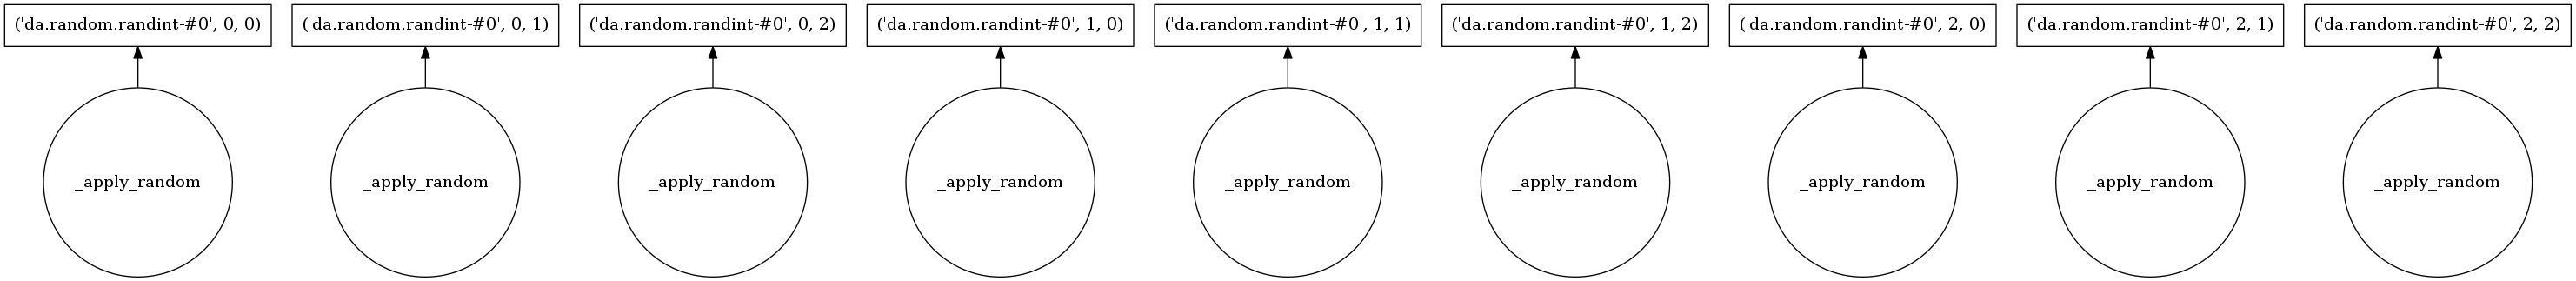

In [26]:
a.visualize() # a = randint(size=(60,60), chunks=(20,20))

#b.visualize() # b = a.T * a + 100

### Dask DataFrames
If you're familiar with the `pandas.dataframe` then the `dask.dataframe` is going to be easy to use

In [27]:
import dask.dataframe as dd

df = dd.demo.make_timeseries('2010', '2016',
                             {'value': float, 'name': str, 'id': int},
                             freq='10s', partition_freq='7d', seed=1)

df = df[df.value > 0][['id', 'value', 'name']]

df.head()

,id,value,name
2010-01-01 00:00:10,955,0.593030,Frank
2010-01-01 00:00:20,991,0.331898,Jerry
2010-01-01 00:00:50,984,0.388256,Xavier
2010-01-01 00:01:00,963,0.197801,Dan
2010-01-01 00:01:20,1019,0.018332,Yvonne


In [30]:
from dask.distributed import Client, progress
c = Client('10.109.226.189:8786')
df = df.persist()
progress(df)

VBox()

In [31]:
%time len(df)

CPU times: user 264 ms, sys: 0 ns, total: 264 ms
Wall time: 470 ms


9464412

In [32]:
%time df.groupby(df.id).value.mean().nlargest(10).compute()

CPU times: user 108 ms, sys: 16 ms, total: 124 ms
Wall time: 919 ms


id
1156    0.908368
852     0.899368
841     0.856013
1173    0.825994
1161    0.822107
1165    0.803438
1152    0.797171
1158    0.732588
854     0.724765
1144    0.716518
Name: value, dtype: float64

In [33]:
%time df.loc['2015-12-25'].head()

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 19.5 ms


,id,value,name
2015-12-25 00:00:00,994,0.919311,Yvonne
2015-12-25 00:00:10,992,0.035872,Zelda
2015-12-25 00:00:20,977,0.772903,Sarah
2015-12-25 00:00:30,1010,0.449239,Laura
2015-12-25 00:00:50,1013,0.380744,Zelda


In [34]:
df.value.std().compute()

0.2886730987276591

In [35]:
df2 = df[df.name == 'Hannah']
df2.head()

,id,value,name
2010-01-01 00:09:40,1014,0.689966,Hannah
2010-01-01 00:23:30,1025,0.445631,Hannah
2010-01-01 00:31:50,1010,0.554102,Hannah
2010-01-01 00:39:40,1026,0.338665,Hannah
2010-01-01 00:49:10,1023,0.632757,Hannah


### Rolling mean

In [37]:
df.value.rolling(100).mean().tail()

2015-12-31 23:58:30    0.479710
2015-12-31 23:58:40    0.475818
2015-12-31 23:59:00    0.478459
2015-12-31 23:59:40    0.476589
2015-12-31 23:59:50    0.478680
Name: value, dtype: float64

In this example we look at a smaller dataset and see how Dask.dataframe would resample data that is organized by month to data that is organized by week. This is a bit messy because weeks and months don't line up perfectly. Fortunately Dask's task scheduler are built for this sort of messy situation.

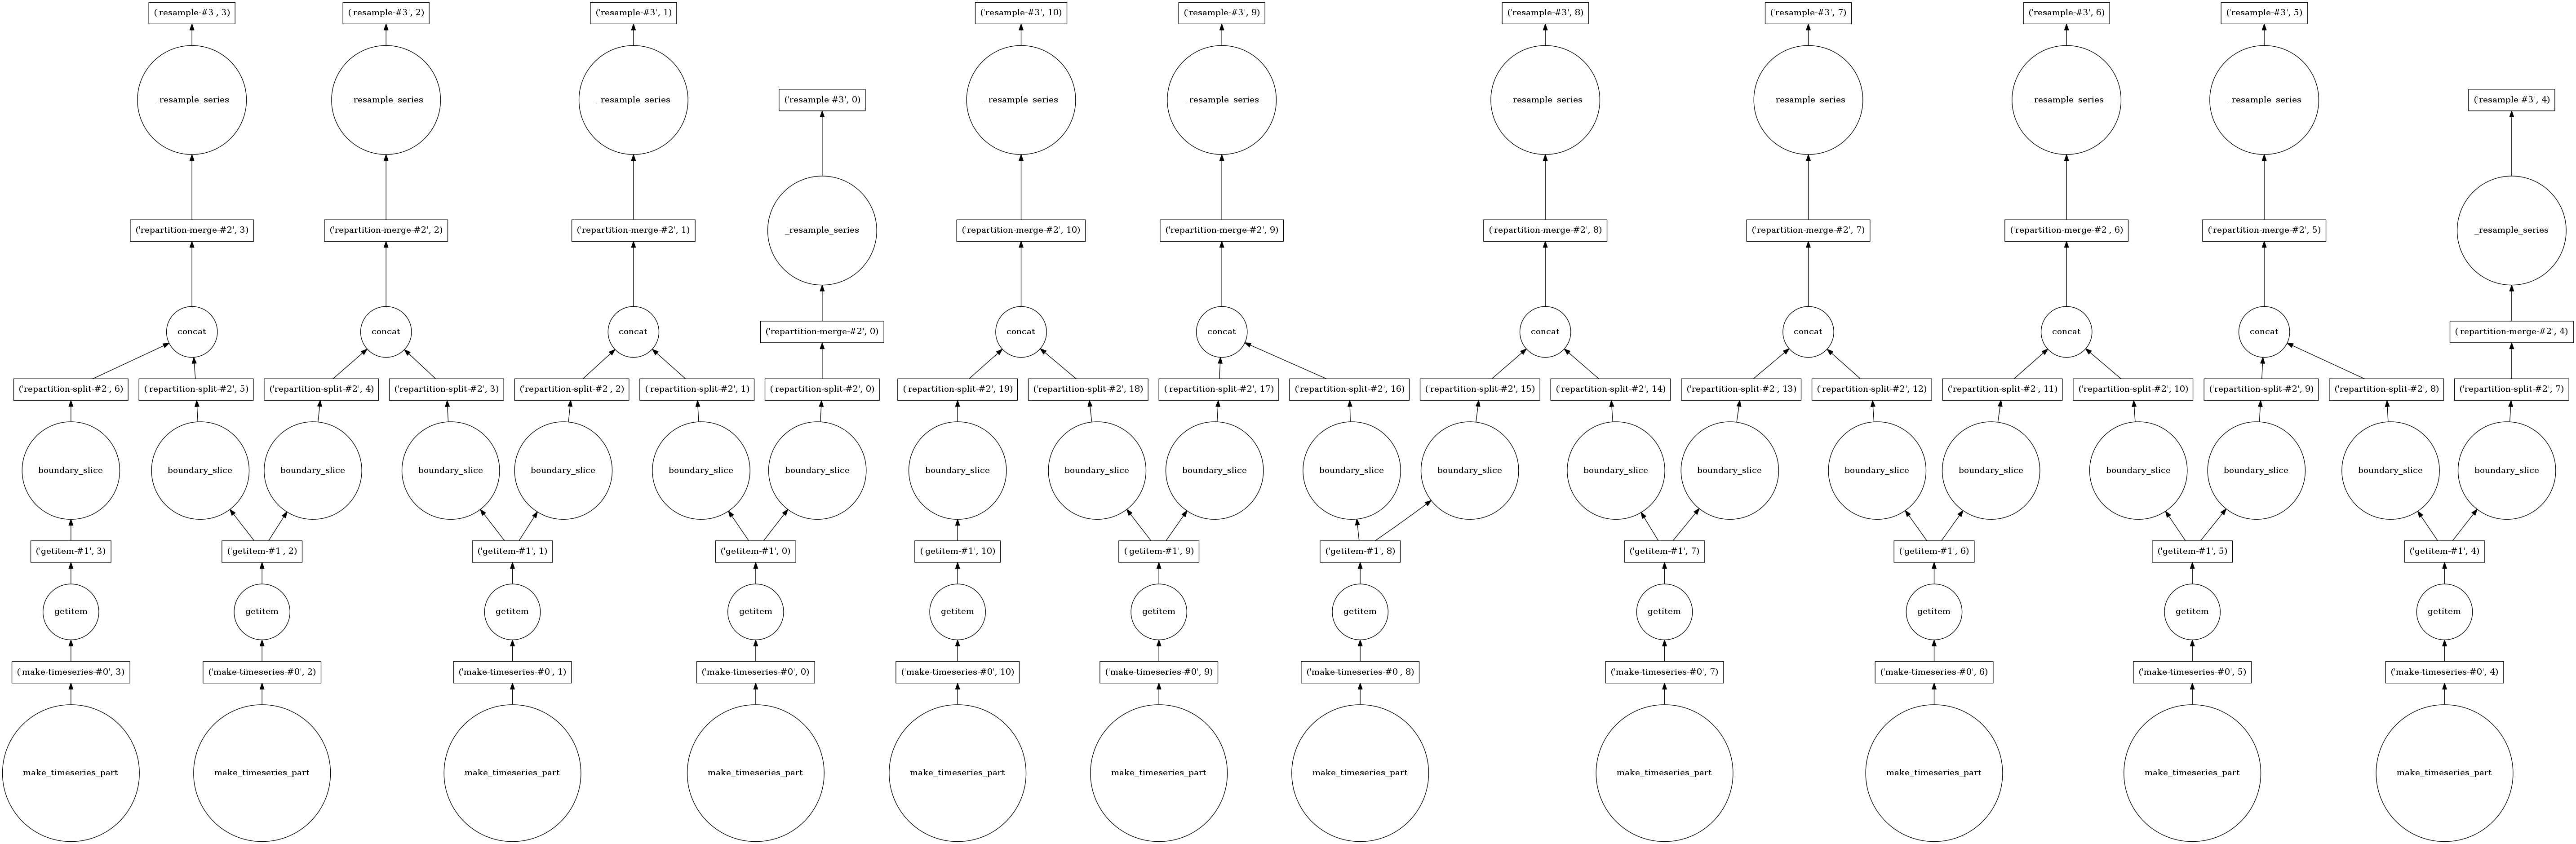

In [38]:
df_small = dd.demo.make_timeseries('2010-01-01', '2010-12-31',
                                   {'value': float, 'name': str, 'id': int},
                                   freq='10s', partition_freq='1M', seed=1)
df_small.value.resample('1w').mean().visualize()

In [43]:
#import matplotlib
#%matplotlib inline
# Pay attention to where .plot() comes in this expression
# df_small[['value']].compute().plot(title='AIG', figsize=(10,4))

## Handson 2/3
### Dask Distributed
### Application to a simple textual task : counting unique words

In [ ]:
from dask.distributed import Client
c = Client('10.109.226.189:8786')

In [ ]:
from dask import delayed
import time

def inc(x):
    time.sleep(5)
    return x + 1

def dec(x):
    time.sleep(3)
    return x - 1

def add(x, y):
    time.sleep(7)
    return x + y

In [ ]:
x = delayed(inc)(1)
y = delayed(dec)(2)
total = delayed(add)(x, y)
total.compute()

In [64]:
#### Load textual data : twitter data on French Bank
#import s3fs
import dask.dataframe as dd
import pandas as pd
#df = dd.read_csv('s3://meetup-fr/data/Twitter_BNP_en.csv')
data = pd.read_csv('https://s3-eu-west-1.amazonaws.com/meetup-fr/data/Twitter_BNP_en.csv',sep='|')

In [65]:
#distributed
df = dd.from_pandas(data,npartitions=2)

In [66]:
df.head()

,Unnamed: 0,tweet_id,user_id,retweets,favorites,text,user_screen_name,user_name,created_at
0,0,8.044748e+17,91781830,0.0,0.0,@Mumbler3 I can't help but think if they didn'...,9.178183e+07,Méls-Manuela A BSc,1.480637e+12
1,1,8.044733e+17,59407334,0.0,0.0,"@john81_33 And if you say Stoke, then the BNP ...",5.940733e+07,Adam Johns,1.480636e+12
2,2,8.044732e+17,4056394833,2.0,1.0,Why is it a surprise? Such folk exist. That le...,4.056395e+09,nico bellic,1.480636e+12
3,3,8.044732e+17,2286111098,0.0,0.0,น่ากลัวอะหื้อ,2.286111e+09,นว.,1.480636e+12
4,4,8.044721e+17,378690563,0.0,0.0,"@BNP_SouthLondon hello, is there anyone I coul...",3.786906e+08,Alahna Kindred,1.480636e+12


In [67]:
len(df)

2858

In [68]:
df.npartitions

2

In [69]:
#compute new column with length of unique words in sentence
#http://dask.pydata.org/en/latest/dataframe-api.html
#DataFrame.apply(func[, axis, args, meta])	Parallel version of pandas.DataFrame.apply
df['text'] = df['text'].apply(lambda s: str(s))

df['nwords'] = df['text'].apply(lambda s: len(set(s.split(' '))))

/opt/conda/lib/python3.6/site-packages/dask/dataframe/core.py:2105: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


In [72]:
df[['text','nwords']].head()

,text,nwords
0,@Mumbler3 I can't help but think if they didn'...,27
1,"@john81_33 And if you say Stoke, then the BNP ...",21
2,Why is it a surprise? Such folk exist. That le...,20
3,น่ากลัวอะหื้อ,1
4,"@BNP_SouthLondon hello, is there anyone I coul...",14


In [80]:
# results = set()
# df['text'].str.lower().str.split().apply(results.update)
df['words'] = df['text'].apply(lambda s: str(s).lower().split(' '))

/opt/conda/lib/python3.6/site-packages/dask/dataframe/core.py:2105: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  warnings.warn(msg)


Dask Series Structure:
npartitions=2
0       object
1429       ...
2857       ...
Name: words, dtype: object
Dask Name: apply, 36 tasks

In [82]:
df['words'].head(3)

0    [@mumbler3, i, can't, help, but, think, if, th...
1    [@john81_33, and, if, you, say, stoke,, then, ...
2    [why, is, it, a, surprise?, such, folk, exist....
Name: words, dtype: object

In [89]:
import re

In [101]:
# remove words with @ (users) and with http (links), remove # and other punctuation in words too.
def filterwords(w):
    punctuation = re.compile(r'#[-.?!,":;()|0-9]')
    r = []
    for x in w:
        if 'http' in x or '@' in x:
            continue
        else:
            r.append(re.sub('[^A-Za-z]+', '', x))
    return r

vocabulary = set()
for i,w in df['words'].iteritems():
    vocabulary.update(filterwords(w))

In [103]:
len(vocabulary)

6339

In [ ]:
#option: restrain to words around #BNP or @BNP

In [ ]:
#**todo: create a function that associates a sentence with a vector, run it in parallel mode with Dask**

## Handson 3/3 A sophisticated task : trying to infer sentiment for each tweet

In [ ]:
#http://dask-ml.readthedocs.io/en/latest/examples/hyperparameter-search.html

In [ ]:
Step 1. Create a vocabulary with the words that are present (done only once)

In [ ]:
Load the dictionnary

In [ ]:
Average the embeddings for each word in each tweet in a distributed way with Dask